#All-Pairs Shortest Paths

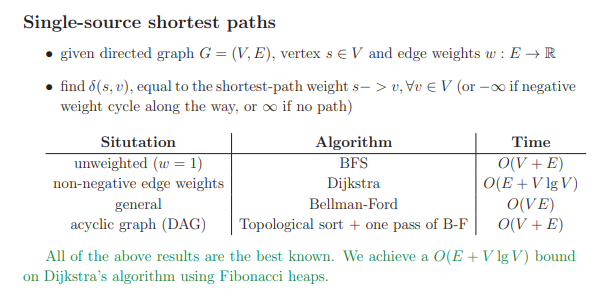

In [ ]:
import heapq

class Graph:
    def __init__(self):
        self.vertices = {}

    def add_vertex(self, vertex):
        if vertex not in self.vertices:
            self.vertices[vertex] = {}

    def add_edge(self, from_vertex, to_vertex, weight):
        self.add_vertex(from_vertex)
        self.add_vertex(to_vertex)
        self.vertices[from_vertex][to_vertex] = weight

    def dijkstra(self, start_vertex):
        # Initialize distances to all vertices as infinity
        distances = {vertex: float('inf') for vertex in self.vertices}
        distances[start_vertex] = 0

        # Initialize priority queue with (distance, vertex) pairs
        priority_queue = [(0, start_vertex)]

        while priority_queue:
            current_distance, current_vertex = heapq.heappop(priority_queue)

            # Ignore outdated entries in the priority queue
            if current_distance > distances[current_vertex]:
                continue

            # Explore neighbors of the current vertex
            for neighbor, weight in self.vertices[current_vertex].items():
                distance = current_distance + weight

                # Update distance if a shorter path is found
                if distance < distances[neighbor]:
                    distances[neighbor] = distance
                    heapq.heappush(priority_queue, (distance, neighbor))

        return distances

# Example usage:
if __name__ == "__main__":
    # Create a graph
    graph = Graph()
    graph.add_edge('A', 'B', 4)
    graph.add_edge('A', 'C', 2)
    graph.add_edge('B', 'C', 5)
    graph.add_edge('B', 'D', 10)
    graph.add_edge('C', 'D', 3)
    graph.add_edge('D', 'E', 7)
    graph.add_edge('E', 'F', 2)
    graph.add_edge('F', 'D', 2)

    # Find shortest paths from vertex 'A'
    shortest_paths = graph.dijkstra('A')
    print("Shortest paths from vertex 'A':", shortest_paths)

Shortest paths from vertex 'A': {'A': 0, 'B': 4, 'C': 2, 'D': 5, 'E': 12, 'F': 14}


Fibonacci Heaps:
(Source: https://github.com/danielborowski/fibonacci-heap-python/blob/master/fib-heap.py)

In [ ]:
import math


class FibonacciHeap:

    # internal node class
    class Node:
        def __init__(self, key, value):
            self.key = key
            self.value = value
            self.parent = self.child = self.left = self.right = None
            self.degree = 0
            self.mark = False

    # function to iterate through a doubly linked list
    def iterate(self, head):
        node = stop = head
        flag = False
        while True:
            if node == stop and flag is True:
                break
            elif node == stop:
                flag = True
            yield node
            node = node.right

    # pointer to the head and minimum node in the root list
    root_list, min_node = None, None

    # maintain total node count in full fibonacci heap
    total_nodes = 0

    # return min node in O(1) time
    def find_min(self):
        return self.min_node

    # extract (delete) the min node from the heap in O(log n) time
    # amortized cost analysis can be found here (http://bit.ly/1ow1Clm)
    def extract_min(self):
        z = self.min_node
        if z is not None:
            if z.child is not None:
                # attach child nodes to root list
                children = [x for x in self.iterate(z.child)]
                for i in range(0, len(children)):
                    self.merge_with_root_list(children[i])
                    children[i].parent = None
            self.remove_from_root_list(z)
            # set new min node in heap
            if z == z.right:
                self.min_node = self.root_list = None
            else:
                self.min_node = z.right
                self.consolidate()
            self.total_nodes -= 1
        return z

    # insert new node into the unordered root list in O(1) time
    # returns the node so that it can be used for decrease_key later
    def insert(self, key, value=None):
        n = self.Node(key, value)
        n.left = n.right = n
        self.merge_with_root_list(n)
        if self.min_node is None or n.key < self.min_node.key:
            self.min_node = n
        self.total_nodes += 1
        return n

    # modify the key of some node in the heap in O(1) time
    def decrease_key(self, x, k):
        if k > x.key:
            return None
        x.key = k
        y = x.parent
        if y is not None and x.key < y.key:
            self.cut(x, y)
            self.cascading_cut(y)
        if x.key < self.min_node.key:
            self.min_node = x

    # merge two fibonacci heaps in O(1) time by concatenating the root lists
    # the root of the new root list becomes equal to the first list and the second
    # list is simply appended to the end (then the proper min node is determined)
    def merge(self, h2):
        H = FibonacciHeap()
        H.root_list, H.min_node = self.root_list, self.min_node
        # fix pointers when merging the two heaps
        last = h2.root_list.left
        h2.root_list.left = H.root_list.left
        H.root_list.left.right = h2.root_list
        H.root_list.left = last
        H.root_list.left.right = H.root_list
        # update min node if needed
        if h2.min_node.key < H.min_node.key:
            H.min_node = h2.min_node
        # update total nodes
        H.total_nodes = self.total_nodes + h2.total_nodes
        return H

    # if a child node becomes smaller than its parent node we
    # cut this child node off and bring it up to the root list
    def cut(self, x, y):
        self.remove_from_child_list(y, x)
        y.degree -= 1
        self.merge_with_root_list(x)
        x.parent = None
        x.mark = False

    # cascading cut of parent node to obtain good time bounds
    def cascading_cut(self, y):
        z = y.parent
        if z is not None:
            if y.mark is False:
                y.mark = True
            else:
                self.cut(y, z)
                self.cascading_cut(z)

    # combine root nodes of equal degree to consolidate the heap
    # by creating a list of unordered binomial trees
    def consolidate(self):
        A = [None] * int(math.log(self.total_nodes) * 2)
        nodes = [w for w in self.iterate(self.root_list)]
        for w in range(0, len(nodes)):
            x = nodes[w]
            d = x.degree
            while A[d] != None:
                y = A[d]
                if x.key > y.key:
                    temp = x
                    x, y = y, temp
                self.heap_link(y, x)
                A[d] = None
                d += 1
            A[d] = x
        # find new min node - no need to reconstruct new root list below
        # because root list was iteratively changing as we were moving
        # nodes around in the above loop
        for i in range(0, len(A)):
            if A[i] is not None:
                if A[i].key < self.min_node.key:
                    self.min_node = A[i]

    # actual linking of one node to another in the root list
    # while also updating the child linked list
    def heap_link(self, y, x):
        self.remove_from_root_list(y)
        y.left = y.right = y
        self.merge_with_child_list(x, y)
        x.degree += 1
        y.parent = x
        y.mark = False

    # merge a node with the doubly linked root list
    def merge_with_root_list(self, node):
        if self.root_list is None:
            self.root_list = node
        else:
            node.right = self.root_list.right
            node.left = self.root_list
            self.root_list.right.left = node
            self.root_list.right = node

    # merge a node with the doubly linked child list of a root node
    def merge_with_child_list(self, parent, node):
        if parent.child is None:
            parent.child = node
        else:
            node.right = parent.child.right
            node.left = parent.child
            parent.child.right.left = node
            parent.child.right = node

    # remove a node from the doubly linked root list
    def remove_from_root_list(self, node):
        if node == self.root_list:
            self.root_list = node.right
        node.left.right = node.right
        node.right.left = node.left

    # remove a node from the doubly linked child list
    def remove_from_child_list(self, parent, node):
        if parent.child == parent.child.right:
            parent.child = None
        elif parent.child == node:
            parent.child = node.right
            node.right.parent = parent
        node.left.right = node.right
        node.right.left = node.left

In [ ]:
class Dijkstra:
    def __init__(self, graph):
        self.graph = graph

    def dijkstra(self, source):
        # Initialize distances
        distance = {vertex: math.inf for vertex in self.graph}
        distance[source] = 0

        # Initialize Fibonacci heap
        fib_heap = FibonacciHeap()
        nodes = {}

        for vertex in self.graph:
            node = fib_heap.insert(distance[vertex], vertex)
            nodes[vertex] = node

        while fib_heap.total_nodes > 0:
            current = fib_heap.extract_min()
            current_vertex = current.value

            # Relax adjacent vertices
            for neighbor, weight in self.graph[current_vertex].items():
                new_distance = distance[current_vertex] + weight
                if new_distance < distance[neighbor]:
                    distance[neighbor] = new_distance
                    fib_heap.decrease_key(nodes[neighbor], new_distance)

        return distance

# Example usage
if __name__ == "__main__":
    graph = {
        'A': {'B': 1, 'C': 4},
        'B': {'A': 1, 'C': 2, 'D': 5},
        'C': {'A': 4, 'B': 2, 'D': 1},
        'D': {'B': 5, 'C': 1}
    }

    dijkstra = Dijkstra(graph)
    distances = dijkstra.dijkstra('A')
    print(distances)

{'A': 0, 'B': 1, 'C': 3, 'D': 4}


#All-pairs shortest paths


#Attempt 1: Dynamic Programming with Floyd Warshall

In [ ]:
import math

class FloydWarshall:
    def __init__(self, graph):
        self.graph = graph
        self.V = len(graph)

    def floyd_warshall(self):
        # Initialize distance matrix with values from the graph
        dist = [[math.inf] * self.V for _ in range(self.V)]
        for i in range(self.V):
            dist[i][i] = 0
            for j in self.graph[i]:
                dist[i][j] = self.graph[i][j]

        # Update the distance matrix
        for k in range(self.V):
            for i in range(self.V):
                for j in range(self.V):
                    dist[i][j] = min(dist[i][j], dist[i][k] + dist[k][j])

        return dist

# Example usage
if __name__ == "__main__":
    graph = {
        0: {1: 3, 2: 6, 3: 15},
        1: {2: -2},
        2: {3: 2},
        3: {}
    }

    fw = FloydWarshall(graph)
    shortest_paths = fw.floyd_warshall()
    for i in range(len(shortest_paths)):
        print(f"Shortest paths from node {i}: {shortest_paths[i]}")


Shortest paths from node 0: [0, 3, 1, 3]
Shortest paths from node 1: [inf, 0, -2, 0]
Shortest paths from node 2: [inf, inf, 0, 2]
Shortest paths from node 3: [inf, inf, inf, 0]


#Attempt 2: Johnson’s algorithm

Source: https://github.com/Anirudh2305/Johnsons-Algorithm/blob/main/JohnsonsAlgo.cpp

In [ ]:
from queue import PriorityQueue

class Graph:
    def __init__(self, num):
        self.V = num
        self.adj = [[] for _ in range(self.V + 1)]

    def addEdge(self, x, y, wt):
        self.adj[x].append((y, wt))

    def printGraph(self):
        for v in range(self.V):
            print("\n Adjacency list of vertex", v, "\n head->", end="")
            for x in self.adj[v]:
                print("(", x[0], ",", x[1], ")", end="")
            print()

def Johnson(V, adj):
    # 1. Add s with 0 edge weights.
    for i in range(V):
        adj[V].append((i, 0))

    # 2. Find h(v) for each V.
    h = BellmanFord(V, adj)

    # 3. Remove s(along with its edges) from adj list and also delete h(V).
    h.pop()
    adj[V].clear()

    # 4. Reweight
    for u in range(V):
        for v in range(len(adj[u])):
            adj[u][v] = (adj[u][v][0], adj[u][v][1] + h[u] - h[adj[u][v][0]])

    # 5. Dijkstra
    SP = Dijkstra(V, adj)

    # 6. Final Answer(Original weights back)
    for u in range(V):
        for v in range(V):
            SP[u][v] += h[v] - h[u]

    # 7. Display
    for u in range(V):
        print(*SP[u])

def BellmanFord(V, adj):
    dist = [float('inf')] * (V + 1)
    dist[V] = 0

    for _ in range(V):
        for u in range(V, -1, -1):
            for x in adj[u]:
                v, wt = x
                if dist[u] != float('inf') and dist[u] + wt < dist[v]:
                    dist[v] = dist[u] + wt

    for u in range(V, -1, -1):
        for x in adj[u]:
            v, wt = x
            if dist[u] != float('inf') and dist[u] + wt < dist[v]:
                print("Negative Cycle")
                exit(1)

    return dist

def Dijkstra(V, adj):
    dist = [[float('inf')] * V for _ in range(V)]
    q = PriorityQueue()

    for i in range(V):
        src = i
        dist[i][i] = 0
        q.put((0, src))

    while not q.empty():
        currDist, node = q.get()
        if dist[i][node] < currDist:
            continue
        for x in adj[node]:
            ver, wt = x
            if wt + dist[i][node] < dist[i][ver]:
                dist[i][ver] = wt + dist[i][node]
                q.put((dist[i][ver], ver))

    return dist

if __name__ == "__main__":
    g = Graph(4)
    g.addEdge(0, 1, 2)
    g.addEdge(1, 0, 1)
    g.addEdge(0, 3, 5)
    g.addEdge(3, 0, 2)
    g.addEdge(1, 2, 1)
    g.addEdge(2, 0, -2)
    g.addEdge(2, 3, -2)

    Johnson(g.V, g.adj)

0 inf inf inf
inf 0 inf inf
inf inf 0 inf
2 4 5 0


#Bellman-Ford System of Constraints

In [ ]:
def bellman_ford_system_of_constraints(n, constraints):
    # Initialize variables
    x = [0] * n

    # Relax constraints repeatedly
    for _ in range(n - 1):
        for i, j, c in constraints:
            if x[i] + c < x[j]:
                x[j] = x[i] + c

    # Check for negative cycles
    for i, j, c in constraints:
        if x[i] + c < x[j]:
            return "Unsolvable"

    return x

# Example usage
if __name__ == "__main__":
    num_variables = 3
    example_constraints = [(0, 1, 2), (1, 2, 3), (2, 0, -4)]

    result = bellman_ford_system_of_constraints(num_variables, example_constraints)
    print("Variable values:", result)

Variable values: [-4, -2, 0]


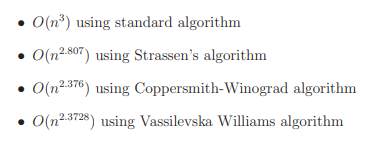

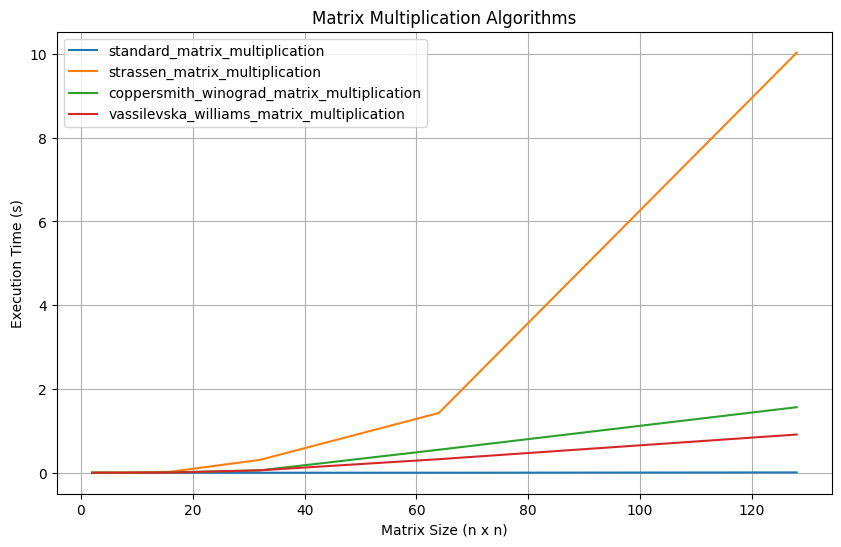

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt

# Standard Matrix Multiplication
def standard_matrix_multiplication(A, B):
    return np.dot(A, B)

# Strassen's Algorithm
def strassen_matrix_multiplication(A, B):
    if len(A) == 1:
        return A * B
    else:
        n = len(A) // 2
        A11, A12 = A[:n, :n], A[:n, n:]
        A21, A22 = A[n:, :n], A[n:, n:]
        B11, B12 = B[:n, :n], B[:n, n:]
        B21, B22 = B[n:, :n], B[n:, n:]

        M1 = strassen_matrix_multiplication(A11 + A22, B11 + B22)
        M2 = strassen_matrix_multiplication(A21 + A22, B11)
        M3 = strassen_matrix_multiplication(A11, B12 - B22)
        M4 = strassen_matrix_multiplication(A22, B21 - B11)
        M5 = strassen_matrix_multiplication(A11 + A12, B22)
        M6 = strassen_matrix_multiplication(A21 - A11, B11 + B12)
        M7 = strassen_matrix_multiplication(A12 - A22, B21 + B22)

        C11 = M1 + M4 - M5 + M7
        C12 = M3 + M5
        C21 = M2 + M4
        C22 = M1 - M2 + M3 + M6

        C = np.vstack((np.hstack((C11, C12)), np.hstack((C21, C22))))
        return C

# Coppersmith-Winograd Algorithm
def coppersmith_winograd_matrix_multiplication(A, B):
    n = len(A)
    C = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            for k in range(n):
                C[i, j] += A[i, k] * B[k, j]

    return C

# Vassilevska Williams Algorithm
def vassilevska_williams_matrix_multiplication(A, B):
    n = len(A)
    C = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            C[i, j] = sum(A[i, k] * B[k, j] for k in range(n))

    return C

# Function to generate random matrix of size n x n
def generate_random_matrix(n):
    return np.random.randint(1, 10, size=(n, n))

# Function to measure execution time of each multiplication algorithm
def measure_execution_time(matrix_multiplication_function, A, B):
    start_time = time.time()
    matrix_multiplication_function(A, B)
    end_time = time.time()
    return end_time - start_time

# Function to plot graphs
def plot_graphs(sizes, times, algorithms):
    plt.figure(figsize=(10, 6))

    for i, algorithm in enumerate(algorithms):
        plt.plot(sizes, times[i], label=algorithm.__name__)

    plt.xlabel('Matrix Size (n x n)')
    plt.ylabel('Execution Time (s)')
    plt.title('Matrix Multiplication Algorithms')
    plt.legend()
    plt.grid(True)
    plt.show()

# Sizes of matrices
sizes = [2**i for i in range(1, 8)]

# Algorithms
algorithms = [standard_matrix_multiplication, strassen_matrix_multiplication, coppersmith_winograd_matrix_multiplication, vassilevska_williams_matrix_multiplication]

# Execution times
times = [[] for _ in range(len(algorithms))]

for size in sizes:
    A = generate_random_matrix(size)
    B = generate_random_matrix(size)

    for i, algorithm in enumerate(algorithms):
        execution_time = measure_execution_time(algorithm, A, B)
        times[i].append(execution_time)

# Plotting the graphs
plot_graphs(sizes, times, algorithms)